<a href="https://colab.research.google.com/github/jamessutton600613-png/GC/blob/main/Copy_of_Untitled176.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install qiskit-aer qiskit

In [ ]:
import os
import sys
import numpy as np # Ensure numpy is imported at the very top
import pandas as pd
import random
import pickle
from datetime import datetime
from google.colab import output
from tqdm.notebook import tqdm
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import google.colab.drive as drive # Use the alias
import glob
import re

# Mount Google Drive to save the output files
drive.mount('/content/drive', force_remount=True)

class QuantumRandomGenerator:
    def __init__(self, num_bits_precision=64):
        self.simulator = AerSimulator()
        self.num_bits = num_bits_precision

    def get_seed(self, entropy_input=None): # Added optional entropy_input
        qc = QuantumCircuit(self.num_bits, self.num_bits)
        qc.h(range(self.num_bits))
        # If entropy_input is provided, potentially use it to influence the circuit
        # For this simple example, we just measure
        qc.measure(range(self.num_bits), range(self.num_bits))
        job = self.simulator.run(transpile(qc, self.simulator), shots=1)
        # Get the result as a bit string and convert to integer
        result = job.result().get_counts(0)
        bitstring = list(result.keys())[0]
        return int(bitstring, 2)


class Environment:
    def __init__(self, rng, days_per_cycle=50):
        self.days_per_cycle, self.time, self.rng = days_per_cycle, 0, rng
        self.steps_per_year = 365 * self.days_per_cycle
        # Generate initial environment data for a fixed number of years (e.g., 50)
        # This ensures we have enough data even for very long simulations
        self._generate_cycles(num_years=50)


    def _generate_cycles(self, num_years):
        # Corrected typo: used self.steps_per_year
        total_steps = num_years * self.steps_per_year
        two_pi = 2 * np.pi # Calculate 2*pi separately
        daily_uv_cycle = np.sin(np.linspace(0, two_pi, self.days_per_cycle)); daily_uv_cycle[daily_uv_cycle < 0] = 0
        daily_temp_swing = -4 * np.cos(np.linspace(0, two_pi, self.days_per_cycle)) # Use the variable
        base_weather_noise = self.rng.standard_normal(total_steps)
        smoothing_window = np.ones(14 * self.days_per_cycle) / (14 * self.days_per_cycle)
        weather_pattern = np.convolve(base_weather_noise, smoothing_window, 'same') * 5.0
        full_uv, full_temp = [], []
        global_step_counter = 0
        for _ in range(num_years):
            uv_severity = self.rng.uniform(0.6, 1.4)
            seasonal_temp_base = 15 - 10 * np.cos(np.linspace(0, two_pi, self.steps_per_year))
            seasonal_amplitude_mod = (0.225 * np.sin(np.linspace(0, two_pi, self.steps_per_year)) + 0.725) * uv_severity
            daily_temp_anomaly = 0
            for i in range(self.steps_per_year):
                if i % self.days_per_cycle == 0: daily_temp_anomaly = self.rng.uniform(-1.5, 1.5)
                cloud_cover_factor = self.rng.uniform(0.7, 1.0)
                daily_uv = daily_uv_cycle[i % self.days_per_cycle] * seasonal_amplitude_mod[i] * cloud_cover_factor
                full_uv.append(daily_uv)
                solar_temp = seasonal_temp_base[i] + daily_temp_swing[i % self.days_per_cycle] + weather_pattern[global_step_counter] + daily_temp_anomaly
                full_temp.append(max(4.0, solar_temp))
                global_step_counter += 1
        # Store the generated cycles as attributes
        self.uv_intensity = np.array(full_uv)
        self.temperature = np.array(full_temp)


    def get_current_uv(self):
        # Ensure environment data wraps around if simulation runs beyond generated years
        return self.uv_intensity[self.time % len(self.uv_intensity)]

    def get_current_temperature(self):
        # Ensure environment data wraps around if simulation runs beyond generated years
        return self.temperature[self.time % len(self.temperature)]

    def step(self):
        self.time += 1


class Protoribosome:
    # Added colony parameter
    def __init__(self, env, colony, strategy, initial_sequence, rng, initial_mass=100.0):
        # Added self.colony
        self.env, self.colony, self.strategy, self.rna_sequence, self.rng = env, colony, strategy, list(initial_sequence), rng
        self.rna_mass = initial_mass
        self.uv_protection_pool = 50.0
        # Initialize damage level to 0.0
        self.rna_damage_level = 0.0
        self.location, self.status = 'shadow_zone', 'ACTIVE'
        # Removed individual nucleotide pools
        # self.nmp_pool = {'A': 100, 'U': 100, 'G': 100, 'C': 100}
        # self.ndp_pool = {'A': 50,  'U': 50,  'G': 50,  'C': 50}
        # self.ntp_pool = {'A': 20,  'U': 20,  'G': 20,  'C': 20}

        # Added peptide production status
        self.peptide_status = 'Unknown' # Can be 'Functional 4-mer', 'Mutant Peptide', 'Failed Production'


        # Modified: Set uv_damage_rate_per_uv to a higher value to encourage damage accumulation
        self.uv_damage_rate_per_uv = 5.0 # Increased from 1.0

        self.repair_rate = 0.5
        self.uv_protection_factor = 0.01
        self.damage_tolerance_threshold = 3.0
        self.mutation_prob = 0.004

    def calculate_protection_score(self):
        score = (len(self.rna_sequence) // 3) * 0.1
        weights = {'UGG':5.0,'UAU':3.0,'UAC':3.0,'UUU':1.5,'UUC':1.5,'UGU':1.0,'UGC':1.0,'AUG':0.75,'CAU':0.5,'CAC':0.5}
        score += sum(weights.get("".join(self.rna_sequence[i:i+3]), 0) for i in range(0, len(self.rna_sequence), 3))
        return score

    def has_stop_codon(self):
        return any("".join(self.rna_sequence[i:i+3]) in {'UAA','UAG','UGA'} for i in range(0, len(self.rna_sequence), 3))

    # Modified to interact with Colony's shared pools
    def _forage_and_phosphorylate(self, current_uv):
        # Foraging: Add NMPs directly to the Colony's shared pool
        for base in self.colony.shared_nmp_pool:
            self.colony.shared_nmp_pool[base] += 5 # Add 5 of each NMP per step to the shared pool

        # Phosphorylation: NMP to NDP (from shared pool)
        nmp_to_ndp_conversions = 1 # Attempt to convert 1 of each NMP to NDP if available
        for base in self.colony.shared_nmp_pool:
            if self.colony.shared_nmp_pool[base] >= nmp_to_ndp_conversions:
                self.colony.shared_nmp_pool[base] -= nmp_to_ndp_conversions
                self.colony.shared_ndp_pool[base] += nmp_to_ndp_conversions
            else:
                # Convert what's available if less than target
                self.colony.shared_ndp_pool[base] += self.colony.shared_nmp_pool[base]
                self.colony.shared_nmp_pool[base] = 0

        # Phosphorylation: NDP to NTP (from shared pool, energy-dependent)
        energy = self.uv_protection_pool * current_uv * 0.1
        ndp_to_ntp_conversions_possible = int(energy / 5) # Energy cost per conversion is 5
        # Check total available NDPs in the shared pool
        total_available_ndp = sum(self.colony.shared_ndp_pool.values())
        ndp_to_ntp_conversions = min(ndp_to_ntp_conversions_possible, total_available_ndp) # Don't convert more than available shared NDPs

        if ndp_to_ntp_conversions > 0:
            # Randomly select NDPs from the shared pool to convert to NTPs
            available_ndp_bases = [base for base, count in self.colony.shared_ndp_pool.items() if count > 0]
            if available_ndp_bases:
                # Use self.rng for random choice within Protoribosome
                for _ in range(ndp_to_ntp_conversions):
                    chosen_base = self.rng.choice(available_ndp_bases)
                    if self.colony.shared_ndp_pool[chosen_base] > 0:
                        self.colony.shared_ndp_pool[chosen_base] -= 1
                        self.colony.shared_ntp_pool[chosen_base] += 1
                    # Re-check available bases in case shared pool is depleted during conversion
                    available_ndp_bases = [base for base, count in self.colony.shared_ndp_pool.items() if count > 0]


    # Modified to interact with Colony's shared pools
    def _replicate_rna(self):
        # Replication requires ACTIVE status and sufficient mass for initial replication
        if self.status != 'ACTIVE' or self.rna_mass < 80:
            return None

        # Calculate required NTPs from the shared pool to synthesize *a second copy* of the RNA sequence
        required_ntps = {base: self.rna_sequence.count(base) for base in 'AUGC'}
        required_ntps_for_doubling = {base: count for base, count in required_ntps.items()} # Needs enough for another copy

        # Check if sufficient NTPs are available in the shared pool for doubling/replication
        if not all(self.colony.shared_ntp_pool.get(base, 0) >= count for base, count in required_ntps_for_doubling.items()):
            return None # Replication fails if not enough shared NTPs for doubling

        # Consume the NTPs required for the second copy from the shared pool
        for base, count in required_ntps_for_doubling.items():
            self.colony.shared_ntp_pool[base] -= count

        # Conceptual mass doubling - ensures enough mass for two protoribosomes
        # We assume the consumed NTPs contribute to the mass increase needed for the second copy.
        # The total mass of the parent after consuming NTPs is effectively doubled,
        # which is then divided between parent and offspring.
        # Both parent and offspring will have mass >= 80 if initial mass was >= 80
        # and enough NTPs were available for doubling.

        offspring_mass = self.rna_mass # The offspring gets a mass equal to the parent's pre-division mass
        self.rna_mass = self.rna_mass # The parent retains its pre-division mass

        # Create the new protoribosome (offspring)
        # Pass the colony reference to the new protoribosome
        return Protoribosome(self.env, self.colony, self.strategy, "".join(self.rna_sequence), self.rng, offspring_mass)


    def step(self, current_uv):
        if self.status == 'INACTIVE': return None # No action if already inactive

        # Pass current_uv to foraging/phosphorylation, which now affects shared pool
        self._forage_and_phosphorylate(current_uv)

        # --- Mutation Logic ---
        if self.rng.random() < self.mutation_prob:
            if len(self.rna_sequence) > 0: # Ensure sequence is not empty
                # Use rng.integers for numpy.random.Generator objects
                mutation_position = self.rng.integers(0, len(self.rna_sequence))
                original_base = self.rna_sequence[mutation_position]
                # Choose a new base different from the original
                available_bases = [b for b in 'AUGC' if b != original_base]
                if available_bases: # Ensure there are other bases to mutate to
                     new_base = self.rng.choice(available_bases)
                     self.rna_sequence[mutation_position] = new_base
                     # Note: After mutation, check for stop codons happens below.
        # --- End Mutation Logic ---

        protection = self.uv_protection_pool * self.uv_protection_factor
        effective_uv = current_uv * max(0.01, 1 - protection)
        self.rna_damage_level += effective_uv * self.uv_damage_rate_per_uv
        self.rna_damage_level = max(0, self.rna_damage_level - self.repair_rate)

        # Status update logic
        has_stop = self.has_stop_codon()

        if self.strategy == 'cautious':
            if has_stop: self.status = 'ARRESTED'
            elif self.status == 'ARRESTED' and not has_stop: self.status = 'ACTIVE'
        elif self.strategy == 'readthrough':
            # Reckless is blind to stop codons - only becomes INACTIVE due to damage
            pass # Do nothing here based on has_stop

        # Check for damage tolerance threshold AFTER considering stop codon effects for Cautious
        if self.rna_damage_level > self.damage_tolerance_threshold:
             self.status = 'INACTIVE' # Damage leads to INACTIVE status

        # Only gain UV protection pool if ACTIVE
        if self.status == 'ACTIVE':
             self.uv_protection_pool += 0.20 * self.calculate_protection_score()


        return self._replicate_rna()

class Colony:
    # Added initial_nmp, initial_ndp, initial_ntp parameters for shared pools
    def __init__(self, env, dna_template, initial_pop_size, steps_per_day, rng, shuffle_rng,
                 initial_shared_nmp={'A': 100000, 'U': 100000, 'G': 100000, 'C': 100000}, # Placeholder high values
                 initial_shared_ndp={'A': 5000, 'U': 5000, 'G': 5000, 'C': 5000}, # Placeholder high values
                 initial_shared_ntp={'A': 2000, 'U': 2000, 'G': 2000, 'C': 2000}): # Placeholder high values

        self.env, self.dna_template, self.steps_per_day = env, dna_template, steps_per_day
        self.max_population = 10000 # Increased max_population
        self.rng, self.shuffle_rng = rng, shuffle_rng

        # Added shared nucleotide pools
        self.shared_nmp_pool = initial_shared_nmp
        self.shared_ndp_pool = initial_shared_ndp
        self.shared_ntp_pool = initial_shared_ntp


        # Modified Protoribosome initialization to pass self (the colony instance)
        self.active_population = [
            Protoribosome(env, self, 'cautious' if i % 2 == 0 else 'readthrough', dna_template, rng)
            for i in range(initial_pop_size)
        ]
        self.inactive_population = []

    def step(self, current_step):
        # Advance the environment's time
        self.env.step() # Added call to step the environment

        current_uv = self.env.get_current_uv()
        next_generation = []
        for p in self.active_population:
            # Corrected Call: Removed the extra 'self.dna_template' argument
            offspring = p.step(current_uv)
            if p.status != 'INACTIVE':
                next_generation.append(p)
            else:
                self.inactive_population.append(p)
            if offspring:
                next_generation.append(offspring)

        self.active_population = next_generation
        if len(self.active_population) > self.max_population:
            self.shuffle_rng.shuffle(self.active_population)
            self.active_population = self.active_population[:self.max_population]

    # Modified to report shared pool totals
    def get_aggregated_data(self):
        data = {
            'cautious': 0, 'readthrough': 0,
            'inactive': 0, # Total inactive count
            'cautious_inactive_count': 0, # Added separate inactive count for Cautious
            'readthrough_inactive_count': 0, # Added separate inactive count for Reckless
            'cautious_avg_damage': 0.0, 'readthrough_avg_damage': 0.0,
            'cautious_stop_count': 0, 'readthrough_stop_count': 0,
            # Added shared pool totals
            'shared_nmp_total': sum(self.shared_nmp_pool.values()),
            'shared_ndp_total': sum(self.shared_ndp_pool.values()),
            'shared_ntp_total': sum(self.shared_ntp_pool.values())
        }
        # Calculate total active population counts first
        data['cautious'] = sum(1 for p in self.active_population if p.strategy == 'cautious')
        data['readthrough'] = sum(1 for p in self.active_population if p.strategy == 'readthrough')
        data['inactive'] = len(self.inactive_population)

        # Separate inactive population by strategy
        for p in self.inactive_population:
             if p.strategy == 'cautious':
                 data['cautious_inactive_count'] += 1
             elif p.strategy == 'readthrough':
                 data['readthrough_inactive_count'] += 1


        if data['cautious'] > 0:
            cautious_pop = [p for p in self.active_population if p.strategy == 'cautious']
            data['cautious_avg_damage'] = sum(p.rna_damage_level for p in cautious_pop) / data['cautious']
            # Removed individual pool sums
            # data['cautious_nmp_total'] = sum(sum(p.nmp_pool.values()) for p in cautious_pop)
            # data['cautdp_total'] = sum(sum(p.ndp_pool.values()) for p in cautious_pop)
            # data['cautious_ntp_total'] = sum(sum(p.ntp_pool.values()) for p in cautious_pop)
            # Only count stop codons for Cautious population in active pop
            data['cautious_stop_count'] = sum(1 for p in cautious_pop if p.has_stop_codon())


        if data['readthrough'] > 0:
            readthrough_pop = [p for p in self.active_population if p.strategy == 'readthrough']
            data['readthrough_avg_damage'] = sum(p.rna_damage_level for p in readthrough_pop) / data['readthrough']
            # Removed individual pool sums
            # data['readthrough_nmp_total'] = sum(sum(p.nmp_pool.values()) for p in readthrough_pop)
            # data['readthrough_ndp_total'] = sum(sum(p.ndp_pool.values()) for p in readthrough_pop)
            # data['readthrough_ntp_total'] = sum(sum(p.ntp_pool.values()) for p in readthrough_pop)
            # Reckless does not count stop codons in active pop (conceptually blind)
            data['readthrough_stop_count'] = 0

        # Note: Currently, avg damage is only calculated for ACTIVE populations.
        # If an inactive protoribosome's state (damage) is needed for analysis,
        # the get_aggregated_data function would need to iterate through inactive_population as well.
        # For now, avg damage is only for active.

        return data

# Print statement before function definitions to help diagnose NameError
print("Defining save_colony_state and load_colony_state functions...")

# Move save_colony_state and load_colony_state definitions here (before run_single_simulation)
def save_colony_state(step, colony, data_log, file_path): # Added file_path and data_log parameters
    """Saves the current state of the Colony and Environment to a file."""
    state = {}
    state['step'] = step

    # Save Environment state
    env = colony.env
    state['environment'] = {
        'days_per_cycle': env.days_per_cycle,
        'time': env.time,
        # Corrected: Use bit_generator.state for newer numpy Generators
        'rng_state': env.rng.bit_generator.state,
        'steps_per_year': env.steps_per_year,
        'uv_intensity': env.uv_intensity,
        'temperature': env.temperature,
    }

    # Save Colony state - Modified to include shared pools
    state['colony'] = {
        'dna_template': colony.dna_template,
        'steps_per_day': colony.steps_per_day,
        'max_population': colony.max_population,
        # Corrected: Use bit_generator.state for newer numpy Generators
        'rng_state': colony.rng.bit_generator.state,
        'shuffle_rng_state': colony.shuffle_rng.getstate(), # Save random rng state
        # Added shared pools to state
        'shared_nmp_pool': colony.shared_nmp_pool,
        'shared_ndp_pool': colony.shared_ndp_pool,
        'shared_ntp_pool': colony.shared_ntp_pool,
    }

    # Save Protoribosome states (active and inactive populations) - Removed pool saving per proto
    def get_protoribosome_state(p):
        return {
            'strategy': p.strategy,
            'rna_sequence': p.rna_sequence,
            # Corrected: Use bit_generator.state for newer numpy Generators
            'rng_state': p.rng.bit_generator.state,
            'rna_mass': p.rna_mass,
            'uv_protection_pool': p.uv_protection_pool,
            'rna_damage_level': p.rna_damage_level,
            'location': p.location,
            'status': p.status,
            # Removed individual pools from state - no need to restore them
            # 'nmp_pool': p.nmp_pool,
            # 'ndp_pool': p.ndp_pool,
            # 'ntp_pool': p.ntp_pool,
            'uv_damage_rate_per_uv': p.uv_damage_rate_per_uv,
            'repair_rate': p.repair_rate,
            'uv_protection_factor': p.uv_protection_factor,
            'damage_tolerance_threshold': p.damage_tolerance_threshold,
            'mutation_prob': p.mutation_prob,
            # Added peptide production status
            'peptide_status': p.peptide_status,
        }

    state['active_population'] = [get_protoribosome_state(p) for p in colony.active_population]
    state['inactive_population'] = [get_protoribosome_state(p) for p in colony.inactive_population]

    # Include the data_log in the saved state for plotting interrupted runs
    state['log'] = data_log # Save the data_log

    # Save the state to file
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    with open(file_path, 'wb') as f:
        pickle.dump(state, f)

    # print(f"Simulation state saved to {os.path.basename(file_path)}") # Keep output cleaner

# Reinstating and fixing load_colony_state - Modified to load shared pools
def load_colony_state(file_path):
    """Loads the simulation state from a file and reconstructs the Colony and Environment."""
    try:
        with open(file_path, 'rb') as f:
            state = pickle.load(f)

        # Reconstruct Environment
        env_state = state['environment']

        # Create a temporary rng for Environment initialization
        # Initialize with None or a dummy value, will set state later
        temp_rng_env = np.random.default_rng(0)

        env = Environment(temp_rng_env, days_per_cycle=env_state['days_per_cycle'])
        env.time = env_state['time']
        env.steps_per_year = env_state['steps_per_year']
        env.uv_intensity = env_state['uv_intensity']
        env.temperature = env_state['temperature']

        # Reconstruct Colony - Modified to load shared pools
        colony_state = state['colony']
        # Create temporary rngs for Colony initialization
        temp_sim_rng = np.random.default_rng(0)
        temp_shuffle_rng = random.Random(0)

        colony = Colony(
            env, # Pass the reconstructed environment
            colony_state['dna_template'],
            initial_pop_size=0, # Initial pop size will be overwritten by loading populations
            steps_per_day=colony_state['steps_per_day'],
            rng=temp_sim_rng, # Pass temporary numpy rng
            shuffle_rng=temp_shuffle_rng, # Pass temporary random rng
            # Load shared pools
            initial_shared_nmp=colony_state.get('shared_nmp_pool', {'A': 0, 'U': 0, 'G': 0, 'C': 0}), # Use get with default for backward compatibility
            initial_shared_ndp=colony_state.get('shared_ndp_pool', {'A': 0, 'U': 0, 'G': 0, 'C': 0}),
            initial_shared_ntp=colony_state.get('shared_ntp_pool', {'A': 0, 'U': 0, 'G': 0, 'C': 0})
        )
        colony.max_population = colony_state['max_population']

        # Restore the state of the main simulation RNGs used by Colony and Environment
        # Corrected: Use bit_generator.state for newer numpy Generators
        colony.rng.bit_generator.state = colony_state['rng_state'] # This is the sim_rng for Colony
        colony.shuffle_rng.setstate(colony_state['shuffle_rng_state']) # This is the shuffle_rng for Colony

        # Now, update the Environment's rng to the restored main simulation rng
        env.rng = colony.rng # The Environment's rng should be the same numpy rng as the Colony's

        # Reconstruct Protoribosomes - Pass the loaded colony instance
        colony.active_population = []
        colony.inactive_population = []

        def reconstruct_protoribosome(proto_state, env_obj, colony_obj): # Added colony_obj parameter
            # Create a new Protoribosome instance with the reconstructed environment and a temporary rng
            # Initialize with a dummy rng state, will set state later
            p_rng = np.random.default_rng(0)
            p = Protoribosome(
                env_obj,
                colony_obj, # Pass the colony instance
                proto_state['strategy'],
                "".join(proto_state['rna_sequence']), # Pass sequence as string for init
                p_rng # Use a temporary rng initially
            )
            # Set attributes from saved state
            p.rna_sequence = proto_state['rna_sequence'] # Restore as list
            p.rna_mass = proto_state['rna_mass']
            p.uv_protection_pool = proto_state['uv_protection_pool']
            p.rna_damage_level = proto_state['rna_damage_level']
            p.location = proto_state['location']
            p.status = proto_state['status']
            # Removed individual pools from state - no need to restore them
            # 'nmp_pool': p.nmp_pool,
            # 'ndp_pool': p.ndp_pool,
            # 'ntp_pool': p.ntp_pool,
            p.uv_damage_rate_per_uv = proto_state['uv_damage_rate_per_uv']
            p.repair_rate = proto_state['repair_rate']
            p.uv_protection_factor = proto_state['uv_protection_factor']
            p.damage_tolerance_threshold = proto_state['damage_tolerance_threshold']
            p.mutation_prob = proto_state['mutation_prob'] # Corrected self attribute name
            # Added peptide production status loading
            p.peptide_status = proto_state.get('peptide_status', 'Unknown') # Use .get with default for backward compatibility


            # Restore the Protoribosome's individual RNG state
            # Corrected: Use bit_generator.state for newer numpy Generators
            p.rng.bit_generator.state = proto_state['rng_state']
            return p

        for proto_state in state.get('active_population', []):
            colony.active_population.append(reconstruct_protoribosome(proto_state, env, colony)) # Pass colony instance

        for proto_state in state.get('inactive_population', []):
            colony.inactive_population.append(reconstruct_protoribosome(proto_state, env, colony)) # Pass colony instance

        loaded_step = state['step']
        # Also load the data_log from the state
        loaded_data_log = state.get('log', [])
        print(f"Simulation state loaded successfully from {os.path.basename(file_path)}. Resuming from step {loaded_step + 1}")

        return loaded_step, colony, env, loaded_data_log

    except FileNotFoundError:
        print(f"Error: State file not found at {file_path}")
        return None, None, None, None # Return None for data_log too
    except Exception as e:
        print(f"An error occurred while loading the state: {e}")
        return None, None, None, None # Return None for data_log too


# Defunct run_single_simulation - logic moved to main_orchestrator
# def run_single_simulation(steps_per_day, rng, shuffle_rng, dna_template, save_dir):
#    ... (logic moved) ...

def main_orchestrator(num_replicas, steps_per_day):
    # Original DNA template
    ORIGINAL_DNA_TEMPLATE = "AUGUGUUACUGG"
    # Length of random sequence to add (in amino acids)
    random_aa_length = 33 # Changed from 100 to 33
    random_nucleotide_length = random_aa_length * 3

    # Generate a random RNA sequence using numpy's Generator for consistency with sim state
    # We need an RNG instance before we can generate the random sequence
    # Let's use the same quantum seed process to get a consistent random sequence
    # across runs and restarts, but use a separate instance so it doesn't
    # advance the main simulation RNG state prematurely.
    # Or, even simpler, just use numpy's default_rng which is globally accessible
    # and seeded later by the main sim_seed.
    # Let's stick to using the main sim_rng's seed source but a separate temp RNG.
    q_rng_init = QuantumRandomGenerator(29)
    init_seed = q_rng_init.get_seed()
    temp_init_rng = np.random.default_rng(seed=init_seed) # Use numpy Generator for sequence generation

    random_sequence = ''.join(temp_init_rng.choice(['A', 'U', 'G', 'C'], random_nucleotide_length))

    # Combine original template with the random sequence
    DNA_TEMPLATE = ORIGINAL_DNA_TEMPLATE + random_sequence
    print(f"Generated DNA Template (Original + {random_aa_length} random AA): {DNA_TEMPLATE}")
    print(f"Total DNA Template length: {len(DNA_TEMPLATE)} bases")


    all_summaries = []
    max_run_steps = 50000 # Define max_run_steps here
    save_interval = 100 # Define save interval here
    initial_pop_size = 5000 # Define initial_pop_size here

    # --- Control Flag for Fresh Start vs. Resume ---
    # Set to True to always start a new simulation from step 0.
    # Set to False to attempt to find and resume the latest checkpoint.
    force_fresh_start = False # <--- Change this line to True or False ---
    # -----------------------------------------------


    # Define a base directory for experiments in Google Drive
    base_save_dir = '/content/drive/My Drive/Colab Notebooks/Sim_Experiments'

    # --- Logic to find the latest experiment directory and its latest replica (used when NOT forcing fresh start) ---
    latest_experiment_dir = None
    latest_replica_dir = None

    if not force_fresh_start: # Only try to find latest if not forcing fresh start
        experiment_dirs = sorted(
            [d for d in glob.glob(os.path.join(base_save_dir, 'Experiment_*')) if os.path.isdir(d)],
            key=os.path.getmtime, # Use modification time for latest
            reverse=True
        )

        if experiment_dirs:
            for exp_dir in experiment_dirs:
                replica_dirs_in_exp = sorted(
                    [d for d in glob.glob(os.path.join(exp_dir, 'Replica_*')) if os.path.isdir(d)],
                    key=os.path.getmtime,
                    reverse=True
                )
                if replica_dirs_in_exp:
                     latest_experiment_dir = exp_dir
                     latest_replica_dir = replica_dirs_in_exp[0]
                     print(f"Found latest experiment directory for resume: {os.path.basename(latest_experiment_dir)}")
                     print(f"Found latest replica directory within it for resume: {os.path.basename(latest_replica_dir)}")
                     break # Found the latest replica in the latest experiment, exit loop


    # --- Determine Experiment Directory ---
    experiment_dir = None
    if force_fresh_start or latest_replica_dir is None:
        # If forcing fresh start OR no previous replica data found, create a new experiment directory
        experiment_dir = os.path.join(base_save_dir, f"Experiment_{datetime.now().strftime('%Y-%m-%d_%H-%M')}")
        os.makedirs(experiment_dir, exist_ok=True)
        if force_fresh_start:
            print(f"--- Fresh Start ---")
            print(f"Creating a new experiment directory: {os.path.basename(experiment_dir)}")
        else: # latest_replica_dir is None
             print(f"No previous simulation data found. Creating a new experiment directory: {os.path.basename(experiment_dir)}")
    else:
        # If not forcing fresh start AND latest replica data found, use its experiment directory
        experiment_dir = latest_experiment_dir
        print(f"Resuming within experiment directory: {os.path.basename(experiment_dir)}")


    for i in range(1, num_replicas + 1):
        print(f"\n--- Processing Replica {i}/{num_replicas} ---")
        # Determine the replica directory to use for this run
        current_replica_dir = None
        attempt_resume_this_replica = False

        if not force_fresh_start and latest_replica_dir and i == 1: # If attempting resume AND processing Replica 1
             current_replica_dir = latest_replica_dir
             attempt_resume_this_replica = True
             print(f"Attempting to resume Replica {i} in directory: {os.path.basename(current_replica_dir)}")
        else: # If forcing fresh start OR starting a new experiment OR processing subsequent replicas
             current_replica_dir = os.path.join(experiment_dir, f"Replica_{i}")
             os.makedirs(current_replica_dir, exist_ok=True)
             if force_fresh_start:
                  print(f"Starting new Replica {i} in directory: {os.path.basename(current_replica_dir)}")
             elif latest_replica_dir and i > 1: # If resuming an experiment but processing a subsequent replica
                  print(f"Starting new Replica {i} in existing experiment directory: {os.path.basename(current_replica_dir)}")
             elif latest_replica_dir is None: # If starting a brand new experiment (caught by experiment_dir logic above, but defensive print)
                  pass # Already printed "Creating a new experiment directory"


        # --- Check for and load latest checkpoint within the determined replica dir (only if attempting resume) ---
        latest_checkpoint_path = None
        colony, data_log, start_step = None, [], 0 # Initialize variables BEFORE potential load

        if attempt_resume_this_replica: # Only try to load if attempting resume for this replica
            checkpoint_files = sorted(glob.glob(os.path.join(current_replica_dir, 'checkpoint_step_*.pkl')))
            if checkpoint_files:
                def extract_step_from_filename(filepath):
                    match = re.search(r'checkpoint_step_(\d+).pkl', os.path.basename(filepath))
                    return int(match.group(1)) if match else -1
                latest_checkpoint_path = max(checkpoint_files, key=extract_step_from_filename)
                # Corrected typo in print statement: used current_replica_dir
                print(f"Found latest checkpoint in {os.path.basename(current_replica_dir)}: {os.path.basename(latest_checkpoint_path)}")


            # Attempt to load only if a checkpoint path was found
            if latest_checkpoint_path and os.path.exists(latest_checkpoint_path):
                print(f"Attempting to load state from: {os.path.basename(latest_checkpoint_path)}")
                loaded_step, loaded_colony, loaded_env, loaded_data_log = load_colony_state(latest_checkpoint_path)
                if loaded_colony: # Check if loading was successful
                     start_step = loaded_step + 1 # Start from the step *after* the checkpoint
                     colony = loaded_colony
                     data_log = loaded_data_log
                     # Need to ensure the environment in the loaded colony is the loaded environment
                     colony.env = loaded_env
                     # Also need to ensure protoribosomes reference the correct loaded environment
                     # When loading, protoribosomes need a reference to the *newly loaded* colony instance
                     for p in colony.active_population + colony.inactive_population:
                          p.env = loaded_env
                          p.colony = colony # Set the colony reference


                     print(f"Successfully resumed Replica {i} from step {start_step}.")

                else:
                     print(f"Failed to load checkpoint {os.path.basename(latest_checkpoint_path)}, starting new simulation for Replica {i}.")


        # --- If no checkpoint loaded or loading failed, initialize a new simulation ---
        if colony is None: # This condition is met if force_fresh_start is True OR if resume attempt failed
            print(f"Starting a new simulation for Replica {i}.")
            # Use the same quantum seed process for the simulation's main RNGs
            q_rng_sim = QuantumRandomGenerator(29)
            sim_seed = q_rng_sim.get_seed()
            sim_rng = np.random.default_rng(seed=sim_seed)
            shuffle_rng = random.Random(sim_seed)
            env = Environment(sim_rng, steps_per_day) # Create environment first
            # Pass the new rngs and env to the new Colony, use NEW initial shared pool amounts
            # Using the placeholder high values we added during the previous shared pool restructuring
            colony = Colony(env, DNA_TEMPLATE, initial_pop_size, steps_per_day, sim_rng, shuffle_rng,
                            initial_shared_nmp={'A': 100000, 'U': 100000, 'G': 100000, 'C': 100000},
                            initial_shared_ndp={'A': 5000, 'U': 5000, 'G': 5000, 'C': 5000},
                            initial_shared_ntp={'A': 2000, 'U': 2000, 'G': 2000, 'C': 2000})
            # Ensure Environment also uses the correct sim_rng (already done in Colony init)
            # colony.env.rng = sim_rng # This line is redundant if env is passed correctly
            data_log = [] # Start with an empty log for a new simulation
            start_step = 0 # Always start from step 0 for a fresh start

            # --- Log initial state at step 0 BEFORE the loop starts ---
            # This ensures the plot starts with actual initial conditions (damage=0, etc.)
            print(f"Logging initial state at step {start_step} (time=0).")
            initial_agg_data = colony.get_aggregated_data()
            initial_agg_data['time'] = start_step # Initial time is 0
            # Get environment conditions at the *initial* time step (env.time is 0)
            initial_agg_data['uv'] = colony.env.get_current_uv()
            initial_agg_data['temp'] = colony.env.get_current_temperature()
            data_log.append(initial_agg_data)
            # --- End Log initial state ---


        print(f"Simulation starting/resuming Replica {i} from step: {start_step}")
        print(f"Initial active population size: {len(colony.active_population)}") # Debug print at start
        print(f"Maximum population allowed: {colony.max_population}") # Debug print max population
        # Print initial/loaded shared pool amounts for verification
        print(f"Shared NMP Pool (start): {sum(colony.shared_nmp_pool.values())}")
        print(f"Shared NDP Pool (start): {sum(colony.shared_ndp_pool.values())}")
        print(f"Shared NTP Pool (start): {sum(colony.shared_ntp_pool.values())}")


        # --- Simulation Loop (moved from run_single_simulation) ---
        # Adjust total in progress bar if resuming
        # Only run if there are steps remaining
        # The loop now starts from start_step, but the log already has the entry for start_step (time=0)
        # So, the first step processed in the loop is start_step
        if start_step < max_run_steps:
            # Ensure the progress bar correctly starts from the determined start_step
            progress_bar = tqdm(desc=f"Simulating Replica {i}", total=max_run_steps, initial=start_step, leave=False)
            # Loop from start_step up to max_run_steps - 1
            for step_count in range(start_step, max_run_steps):
                # print(f"Step {step_count}: Active population before step: {len(colony.active_population)}") # Debug print before step - Commented out for cleaner output
                colony.step(step_count) # Process step_count

                # Log data periodically, now including the time step.
                # Log the state *after* processing step `step_count`.
                # The time recorded in the log should be `step_count + 1`.
                # We want logs at 0, 10, 20, ...
                # The initial log is at time 0. Subsequent logs should be after processing step 9, 19, 29...
                # i.e., when (step_count + 1) is a multiple of 10.
                if (step_count + 1) % 10 == 0:
                    agg_data = colony.get_aggregated_data()
                    agg_data['time'] = step_count + 1 # Record the time *after* processing step_count
                    # Get environment conditions at the time *after* processing step_count (colony.env.time is already incremented)
                    agg_data['uv'] = colony.env.get_current_uv()
                    agg_data['temp'] = colony.env.get_current_temperature()
                    data_log.append(agg_data)
                    # print(f"Step: {step_count}, Logged time: {step_count + 1}, data_log length: {len(data_log)}") # Debug print inside logging


                # Implement periodic saving
                # Save at save_interval, at the very last step, or upon extinction
                # Save checkpoint at step_count if (step_count + 1) is a multiple of save_interval,
                # OR if step_count is the last step, OR if population goes extinct *during* this step.
                # Check for extinction AFTER colony.step
                if (step_count + 1) % save_interval == 0 or step_count == max_run_steps - 1 or len(colony.active_population) == 0:
                     print(f"--- Saving checkpoint at step {step_count} (time {step_count + 1}) ---") # Print statement before saving
                     checkpoint_file = os.path.join(current_replica_dir, f'checkpoint_step_{step_count}.pkl') # Use step_count in filename
                     # Pass data_log to save_colony_state
                     save_colony_state(step_count, colony, data_log, checkpoint_file)


                # Update progress bar periodically
                if step_count % 50 == 0:
                    # Ensure data_log is not empty before accessing its last element
                    # The last entry in data_log corresponds to the state *after* the last logged step
                    c = data_log[-1].get('cautious', 0) if data_log else 0
                    r = data_log[-1].get('readthrough', 0) if data_log else 0
                    progress_bar.set_postfix_str(f"Cautious:{c}, Reckless:{r}")


                progress_bar.update(1)
                # print(f"Step {step_count}: Active population after step: {len(colony.active_population)}") # Debug print after step - Commented out for cleaner output

                # Check for extinction AFTER the step is processed and potentially logged/saved
                if len(colony.active_population) == 0:
                    print("--- Population extinct. ---")
                    # Save final state as extinct (already handled by periodic save check above if extinction occurs)
                    # Ensure the final log is saved correctly when breaking due to extinction
                    # The last checkpoint save should have captured the state just before extinction
                    # We can optionally save a final log here too if needed, but checkpoint might be sufficient
                    if (step_count + 1) % save_interval != 0: # Only save if not already saved by interval
                         print(f"--- Saving final log on extinction at step {step_count} (time {step_count + 1}) ---")
                         final_log_path = os.path.join(current_replica_dir, 'simulation_log_extinct.pkl') # Use current_replica_dir
                         log_df = pd.DataFrame(data_log)
                         with open(final_log_path, 'wb') as f:
                             pickle.dump({'log': log_df.to_dict('records')}, f)

                    break # Exit the step loop if extinct


            # Close the progress bar only if it was created and not already closed (e.g., by completing total steps)
            if 'progress_bar' in locals():
                 progress_bar.close()


            # If simulation completed without extinction, save final log
            # Check if loop finished all steps AND population is still > 0
            if step_count == max_run_steps - 1 and len(colony.active_population) > 0:
                 print(f"Simulation completed {max_run_steps} steps.")
                 # The last checkpoint save at step_count == max_run_steps - 1 should be the final log
                 # We can optionally save a separate simulation_log_completed.pkl if desired, but checkpoint is primary
                 # print(f"--- Saving final log on completion at step {step_count} (time {step_count + 1}) ---")
                 # final_log_path = os.path.join(current_replica_dir, 'simulation_log_completed.pkl') # Use current_replica_dir
                 # log_df = pd.DataFrame(data_log)
                 # with open(final_log_path, 'wb') as f:
                 #     pickle.dump({'log': log_df.to_dict('records')}, f)


        else:
             print(f"Replica {i} already completed {max_run_steps} steps or more.")


        print(f"Simulation finished for Replica {i}.")

        # Calculate summary and return (details_df is the final log_df for this replica)
        # Ensure data_log is converted to DataFrame for summary even if simulation didn't run
        log_df = pd.DataFrame(data_log)
        final_agg = colony.get_aggregated_data() if colony else {'cautious': 0, 'readthrough': 0} # Handle case if colony wasn't initialized
        # Determine the actual duration from the log, or max_run_steps if completed
        current_duration = log_df['time'].iloc[-1] if not log_df.empty else 0 # Use the last logged time step for duration


        winner = "Cautious" if final_agg.get('readthrough', 0) == 0 and final_agg.get('cautious', 0) > 0 else "Reckless" if final_agg.get('cautious', 0) == 0 and final_agg.get('readthrough', 0) > 0 else "Tie/Extinction"
        summary = {'Winner':winner,'Duration':current_duration,'Final Cautious':final_agg.get('cautious', 0),'Final Reckless':final_agg.get('readthrough', 0)}
        summary['Replica'] = i
        all_summaries.append(summary)

        print(f"Data for Replica {i} saved in: {current_replica_dir}") # Use current_replica_dir

    print("\n\n" + "="*80 + "\n" + " EXPERIMENT SUMMARY ".center(80, "="))
    if all_summaries:
        summary_df = pd.DataFrame(all_summaries).set_index('Replica')
        print(summary_df.to_string())
    print("="*80)

if __name__ == "__main__":
    # Run 2 replicas with 10 steps per day for demonstration
    main_orchestrator(num_replicas=2, steps_per_day=10)

Mounted at /content/drive
Defining save_colony_state and load_colony_state functions...
Generated DNA Template (Original + 33 random AA): AUGUGUUACUGGGUUCGCGCGUUUGCACUUCUCCCAACCCGGGUUCAGUACCCGUCAAGAUAAUGCCGAGUCCCCUAAUCUUGGACGGAAGACAGUGAGCAGGAAAUGACC
Total DNA Template length: 111 bases
Found latest experiment directory for resume: Experiment_2025-07-05_23-15
Found latest replica directory within it for resume: Replica_1
Resuming within experiment directory: Experiment_2025-07-05_23-15

--- Processing Replica 1/2 ---
Attempting to resume Replica 1 in directory: Replica_1
Found latest checkpoint in Replica_1: checkpoint_step_1099.pkl
Attempting to load state from: checkpoint_step_1099.pkl
Simulation state loaded successfully from checkpoint_step_1099.pkl. Resuming from step 1100
Successfully resumed Replica 1 from step 1100.
Simulation starting/resuming Replica 1 from step: 1100
Initial active population size: 10000
Maximum population allowed: 10000
Shared NMP Pool (start): 170582368
Sha

Simulating Replica 1:   2%|2         | 1100/50000 [00:00<?, ?it/s]

--- Saving checkpoint at step 1199 (time 1200) ---
--- Saving checkpoint at step 1299 (time 1300) ---
--- Saving checkpoint at step 1399 (time 1400) ---
--- Saving checkpoint at step 1499 (time 1500) ---
--- Saving checkpoint at step 1599 (time 1600) ---
--- Saving checkpoint at step 1699 (time 1700) ---
--- Saving checkpoint at step 1799 (time 1800) ---
--- Saving checkpoint at step 1899 (time 1900) ---
--- Saving checkpoint at step 1999 (time 2000) ---
--- Saving checkpoint at step 2099 (time 2100) ---
--- Saving checkpoint at step 2199 (time 2200) ---
--- Saving checkpoint at step 2299 (time 2300) ---
--- Saving checkpoint at step 2399 (time 2400) ---
--- Saving checkpoint at step 2499 (time 2500) ---
--- Saving checkpoint at step 2599 (time 2600) ---
--- Saving checkpoint at step 2699 (time 2700) ---
--- Saving checkpoint at step 2799 (time 2800) ---
--- Saving checkpoint at step 2899 (time 2900) ---
--- Saving checkpoint at step 2999 (time 3000) ---
--- Saving checkpoint at step 3

KeyboardInterrupt: 

In [ ]:
%matplotlib inline
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import re
from datetime import datetime # Import datetime for comparison
from IPython.display import display # Corrected import for display

# ===================================================================
# === 1. SET THE BASE PATH TO YOUR SIMULATION EXPERIMENTS FOLDER ===
# ===================================================================
# This path should point to the folder where the Simulation Runner creates
# the timestamped experiment subfolders (e.g., 'Sim_Experiments').
BASE_EXPERIMENTS_PATH = '/content/drive/My Drive/Colab Notebooks/Sim_Experiments'
# ===================================================================

def find_latest_simulation_log(base_path):
    """
    Finds the absolute latest primary simulation log file (completed or extinct)
    or the latest checkpoint file across all replica directories in the latest
    experiment directory.
    """
    if not os.path.exists(base_path):
        print(f"Error: Base experiments path not found at {base_path}") # Corrected variable name
        return None, None # Return file path and display name

    # Find all experiment directories, sorted by creation/modification time
    experiment_dirs = sorted(
        [d for d in glob.glob(os.path.join(base_path, 'Experiment_*')) if os.path.isdir(d)],
        key=os.path.getmtime, # Use modification time for latest
        reverse=True
    )

    if not experiment_dirs:
        print(f"Error: No experiment directories found in {base_path}")
        return None, None

    # Find the absolute latest data file (log or checkpoint) across all replicas
    latest_file_path = None
    latest_file_mtime = 0 # Track modification time of the latest file
    latest_file_display_name = None

    # We only need to search the latest experiment directory found
    # Iterate through experiment_dirs starting from the latest
    for exp_dir in experiment_dirs:
        # Look for files in *all* replica directories within this experiment
        replica_dirs = [d for d in glob.glob(os.path.join(exp_dir, 'Replica_*')) if os.path.isdir(d)]

        # Sort replica directories by modification time as well to find the latest replica first
        replica_dirs.sort(key=os.path.getmtime, reverse=True)


        for rep_dir in replica_dirs:
            # Look for final logs and checkpoints in this replica directory
            possible_files = (
                glob.glob(os.path.join(rep_dir, 'simulation_log_completed.pkl')) +
                glob.glob(os.path.join(rep_dir, 'simulation_log_extinct.pkl')) +
                glob.glob(os.path.join(rep_dir, 'simulation_log.pkl')) + # Include old format
                glob.glob(os.path.join(rep_dir, 'checkpoint_step_*.pkl'))
            )

            # Sort possible files within this replica by modification time to prioritize latest
            possible_files.sort(key=os.path.getmtime, reverse=True)


            for file_path in possible_files:
                try:
                    file_mtime = os.path.getmtime(file_path)
                    # We want the ABSOLUTE latest file across all replicas and experiments
                    # So we compare against the latest_file_mtime found so far globally
                    if file_mtime > latest_file_mtime:
                        latest_file_mtime = file_mtime
                        latest_file_path = file_path
                        # Construct a display name showing experiment/replica/filename
                        rel_path = os.path.relpath(file_path, base_path)
                        latest_file_display_name = rel_path
                        # Add (from checkpoint) if it's a checkpoint
                        if 'checkpoint_step_' in os.path.basename(file_path):
                             latest_file_display_name += " (from checkpoint)"
                         # Once we find the latest file, we can stop searching
                         # This assumes the sorting by time correctly gives us the latest overall
                         # This break will exit the inner loop (over files), then the next break
                         # will exit the replica loop, and the outer break the experiment loop.
                         # No need for break here, as the sorting ensures we find the latest first
                         # The check below will handle exiting outer loops if the latest is found
                except Exception as e:
                    print(f"Error checking file {file_path}: {e}")
                    continue # Skip to the next file on error


            # After checking all files in this replica, if we have found a latest_file_path
            # and its modification time is newer than this replica directory's modification time,
            # it means the latest file isn't in a *newer* replica directory.
            # However, the sorting of replica_dirs already handles this.
            # The logic here was likely intended to optimize, but was syntactically incorrect.
            # Removing the incorrect `if latest_file_path and os.path.getmtime(rep_dir) <= latest_file_mtime:` line and its break.
            pass # Syntactically correct way to do nothing


        # After checking all replicas in this experiment, if we have found a latest_file_path
        # and its modification time is newer than this experiment directory's modification time,
        # it means the latest file isn't in a *newer* experiment directory.
        # However, the sorting of experiment_dirs already handles this.
        # Removing the incorrect `if latest_file_path and os.path.getmtime(exp_dir) <= latest_file_mtime:` line and its break.
        pass # Syntactically correct way to do nothing


    if latest_file_path:
        print(f"Found latest data file: {latest_file_display_name}")
        return latest_file_path, latest_file_display_name
    else:
        print(f"Error: No primary simulation log file or checkpoint found in any replica directory within {base_path}.")
        return None, "No data found"


def plot_simulation_details(results_df, file_name=""):
    """
    Generates and displays the four plots you specified.
    Handles potentially incomplete DataFrames gracefully.
    """
    if results_df.empty:
        print("The DataFrame is empty. No data to plot.")
        return

    # Calculate Stop Codon Percentages safely, avoiding division by zero
    # The fillna(0) handles cases where the population for a strategy is 0
    # Use the raw counts from the log for the percentage calculation
    results_df['cautious_stop_pct'] = (results_df['cautious_stop_count'] * 100 / results_df['cautious'].replace(0, np.nan)).fillna(0) # Use replace(0, np.nan) to avoid division by zero
    results_df['reckless_stop_pct'] = (results_df['readthrough_stop_count'] * 100 / results_df['readthrough'].replace(0, np.nan)).fillna(0) # This should always be 0 based on logging logic


    fig, axs = plt.subplots(4, 1, figsize=(15, 24), sharex=True, gridspec_kw={'hspace': 0.5}) # Reverted to 4 plots
    fig.suptitle(f'Simulation Analysis for: {file_name}', fontsize=16)
    colors = {'cautious': 'orange', 'readthrough': 'purple'}
    # Adjust rolling window based on data size
    # Use a window that is at most 10% of the data length, but not more than 100
    rolling_window = min(100, max(1, len(results_df) // 10))
    print(f"Using rolling window size for smoothing: {rolling_window}")


    # Plot 1: Environmental Conditions (UV and Temperature)
    ax = axs[0]
    ax.set_title('Environmental Conditions')
    ax.plot(results_df['time'], results_df['uv'], color='gray', alpha=0.5, label='Daily UV')
    # Apply rolling mean only if there's enough data points
    if len(results_df) >= rolling_window:
        ax.plot(results_df['time'], results_df['uv'].rolling(window=rolling_window, min_periods=1).mean(), color='black', label='UV Trend')
    else:
         ax.plot(results_df['time'], results_df['uv'].rolling(window=len(results_df)//2 or 1, min_periods=1).mean(), color='black', label='UV Trend (Smoothed)') # Use smaller window if data is short

    ax.set_ylabel('UV Intensity'); ax.legend(loc='upper left')
    ax_t = ax.twinx()
    ax_t.plot(results_df['time'], results_df['temp'], color='lightcoral', alpha=0.5, label='Daily Temp')
    # Apply rolling mean only if there's enough data points
    if len(results_df) >= rolling_window:
        ax_t.plot(results_df['time'], results_df['temp'].rolling(window=rolling_window, min_periods=1).mean(), color='red', label='Temp Trend')
    else:
        ax_t.plot(results_df['time'], results_df['temp'].rolling(window=len(results_df)//2 or 1, min_periods=1).mean(), color='red', label='Temp Trend (Smoothed)') # Use smaller window if data is short

    ax_t.set_ylabel('Temperature (°C)', color='r'); ax_t.legend(loc='upper right')

    # Plot 2: Population Dynamics (Log Scale)
    ax = axs[1] # Changed to use the second subplot (index 1)
    ax.set_title('Active Population Dynamics (Log Scale)')
    # Only plot if columns exist and have data
    if 'cautious' in results_df.columns and not results_df['cautious'].isnull().all():
        ax.plot(results_df['time'], results_df['cautious'], label='Cautious', color=colors['cautious'])
    if 'readthrough' in results_df.columns and not results_df['readthrough'].isnull().all():
        ax.plot(results_df['time'], results_df['readthrough'], label='Reckless', color=colors['readthrough'])

    ax.set_yscale('log'); ax.set_ylabel('Count'); ax.legend()
    # Handle cases where log scale might fail due to zero values
    if (results_df['cautious'] == 0).all() and (results_df['readthrough'] == 0).all():
         ax.set_yscale('linear') # Switch to linear scale if all are zero
         ax.set_title('Active Population Dynamics (Linear Scale - All Zero)')


    # Plot 3: RNA Damage & Genetic Load
    ax = axs[2] # Changed to use the third subplot (index 2)
    ax.set_title('RNA Damage & Genetic Load')
    # Only plot if columns exist and have data
    if 'cautious_avg_damage' in results_df.columns and not results_df['cautious_avg_damage'].isnull().all():
        ax.plot(results_df['time'], results_df['cautious_avg_damage'], label='Cautious Avg. Damage', color=colors['cautious'])
    if 'readthrough_avg_damage' in results_df.columns and not results_df['readthrough_avg_damage'].isnull().all():
        ax.plot(results_df['time'], results_df['readthrough_avg_damage'], label='Reckless Avg. Damage', color=colors['readthrough'], alpha=0.8)

    ax.set_ylabel('Average RNA Damage Level'); ax.legend(loc='upper left')
    ax_t = ax.twinx()
    # Only plot if columns exist and have data
    if 'cautious_stop_pct' in results_df.columns and not results_df['cautious_stop_pct'].isnull().all() and not (results_df['cautious_stop_pct'] == 0).all(): # Only plot if there's non-zero data
        ax_t.plot(results_df['time'], results_df['cautious_stop_pct'], label='Cautious Stop %', color=colors['cautious'], linestyle='--')
    if 'reckless_stop_pct' in results_df.columns and not results_df['reckless_stop_pct'].isnull().all() and not (results_df['reckless_stop_pct'] == 0).all(): # Only plot if there's non-zero data
        # This should always be 0 if logging is correct, but plotting it confirms
        ax_t.plot(results_df['time'], results_df['reckless_stop_pct'], label='Reckless Stop %', color=colors['readthrough'], linestyle='--')

    ax_t.set_ylabel('Population with Stop Codon (%)'); ax_t.legend(loc='upper right')


    # Plot 4: Inactives and Nucleotide Pools
    ax = axs[3] # Changed to use the fourth subplot (index 3)
    ax.set_title('Inactive Population and Nucleotide Reserves')
    # Plot separate inactive counts if available and data exists
    if 'cautious_inactive_count' in results_df.columns and not results_df['cautious_inactive_count'].isnull().all() and not (results_df['cautious_inactive_count'] == 0).all():
        ax.plot(results_df['time'], results_df['cautious_inactive_count'], label='Cautious Inactive', color=colors['cautious'], linestyle=':')
    if 'readthrough_inactive_count' in results_df.columns and not results_df['readthrough_inactive_count'].isnull().all() and not (results_df['readthrough_inactive_count'] == 0).all():
        ax.plot(results_df['time'], results_df['readthrough_inactive_count'], label='Reckless Inactive', color=colors['readthrough'], linestyle=':')
    # Keep total inactive plot for reference if needed, plot only if not all zero
    if 'inactive' in results_df.columns and not results_df['inactive'].isnull().all() and not (results_df['inactive'] == 0).all():
        ax.plot(results_df['time'], results_df['inactive'], label='Total Inactive', color='black', lw=2, alpha=0.5)
    # If all inactive counts (total and separate) are zero, ensure the y-axis is not log and title reflects zero
    if (results_df['cautious_inactive_count'] == 0).all() and (results_df['readthrough_inactive_count'] == 0).all() and (results_df['inactive'] == 0).all():
         ax.set_title('Inactive Population (All Zero)')


    ax.set_ylabel('Inactive Population Count'); ax.legend(loc='upper left')
    ax_t = ax.twinx()

    # Only plot if columns exist and have data
    # Check if any nucleotide data exists before attempting to plot or show legend for twinx
    nucleotide_cols = ['shared_nmp_total', 'shared_ndp_total', 'shared_ntp_total'] # Updated column names for shared pools
    if any(col in results_df.columns and not results_df[col].isnull().all() and not (results_df[col] == 0).all() for col in nucleotide_cols): # Only plot if there's non-zero data
        # Plot shared nucleotide pools
        if 'shared_nmp_total' in results_df.columns and not results_df['shared_nmp_total'].isnull().all() and not (results_df['shared_nmp_total'] == 0).all():
            ax_t.plot(results_df['time'], results_df['shared_nmp_total'], color='blue', alpha=0.6, label='Shared NMP')
        if 'shared_ndp_total' in results_df.columns and not results_df['shared_ndp_total'].isnull().all() and not (results_df['shared_ndp_total'] == 0).all():
            ax_t.plot(results_df['time'], results_df['shared_ndp_total'], color='green', alpha=0.6, label='Shared NDP')
        if 'shared_ntp_total' in results_df.columns and not results_df['shared_ntp_total'].isnull().all() and not (results_df['shared_ntp_total'] == 0).all():
            ax_t.plot(results_df['time'], results_df['shared_ntp_total'], color='red', alpha=1.0, label='Shared NTP')


        ax_t.set_ylabel('Total Shared Nucleotides in VAT') # Removed color here
        # Only show legend for ax_t if any nucleotide data was plotted on it
        handles_t, labels_t = ax_t.get_legend_handles_labels()
        if handles_t:
             ax_t.legend(loc='upper right')


    for ax_item in axs:
        ax_item.grid(True, linestyle=':', linewidth='0.5', color='gray')
        # Set x-label only on the bottom plot
        if ax_item == axs[-1]:
             ax_item.set_xlabel('Simulation Time Step')
        else:
             ax_item.set_xlabel('') # Remove x-label from upper plots


    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust rect to make space for suptitle
    plt.show()
    plt.close(fig)

# --- Main Execution Logic for this Cell ---
DATA_FILE_PATH, DISPLAY_FILE_NAME = find_latest_simulation_log(BASE_EXPERIMENTS_PATH)

# Initialize results_df to an empty DataFrame before loading
results_df = pd.DataFrame()

if DATA_FILE_PATH and os.path.exists(DATA_FILE_PATH):
    try:
        print(f"Loading data from {os.path.basename(DATA_FILE_PATH)}...")
        with open(DATA_FILE_PATH, 'rb') as f:
            saved_data = pickle.load(f)

        # Check if the loaded data is a full state (from checkpoint) or just the log
        if isinstance(saved_data, dict) and 'log' in saved_data:
            # It's a log file (from a completed/extinct run or older format, or periodically saved log)
            # Ensure data is assigned to results_df only here
            results_df = pd.DataFrame(saved_data['log'])
            print(f"Successfully loaded log with {len(results_df)} entries.")
        elif isinstance(saved_data, dict) and 'step' in saved_data and 'colony' in saved_data and 'environment' in saved_data:
            # It's a checkpoint file containing the full state.
            # Load the data_log which is now saved within the checkpoint state
            if 'log' in saved_data:
                 results_df = pd.DataFrame(saved_data['log'])
                 print(f"Successfully loaded data_log from checkpoint with {len(results_df)} entries.")
            else:
                 print("Error: Checkpoint file does not contain a saved 'log'. Cannot plot from this checkpoint format.")
                 print("Please ensure the simulation is running with the latest code that saves the data_log within checkpoints.")
                 # If loading fails, ensure results_df remains empty
                 results_df = pd.DataFrame() # Explicitly set to empty


        else:
            print("Error: The loaded pickle file has an unexpected format.")
            print(f"Loaded data type: {type(saved_data)}")
            # If loading fails, ensure results_df remains empty
            results_df = pd.DataFrame() # Explicitly set to empty


    except Exception as e:
        print(f"\n--- ERROR: Could not load or plot the data file. ---")
        print(f"The error was: {e}")
        # If loading fails, ensure results_df remains empty
        results_df = pd.DataFrame() # Explicitly set to empty

else:
    print(f"--- ERROR: Could not find or access the latest simulation log file or checkpoint. ---")
    print(f"Please ensure the BASE_EXPERIMENTS_PATH is correct and that simulation runs have completed or been interrupted after at least one checkpoint was saved.")
    # If no file found, ensure results_df remains empty
    results_df = pd.DataFrame() # Explicitly set to empty


# Only attempt to plot if results_df is not empty
if not results_df.empty:
    plot_simulation_details(results_df, file_name=DISPLAY_FILE_NAME)
else:
    print("No data loaded into DataFrame to plot.")

Error: Base experiments path not found at /content/drive/My Drive/Colab Notebooks/Sim_Experiments
--- ERROR: Could not find or access the latest simulation log file or checkpoint. ---
Please ensure the BASE_EXPERIMENTS_PATH is correct and that simulation runs have completed or been interrupted after at least one checkpoint was saved.
No data loaded into DataFrame to plot.


# Task
Refine the simulation code to incorporate RNA damage accumulation, link peptide production status to protoribosome state, implement generalized mutation and repair across the RNA sequence, and adjust stop codon handling based on the Cautious vs. Reckless strategies and the role of damaged Tryptophan codons as a pause signal for both species. Then, run the simulation and plot the results.

## Refine protoribosome state

### Subtask:
Add attributes to track the RNA sequence, potentially track damage on specific bases or regions, and add a state variable representing the "Peptide Production Status" (e.g., 'Functional 4-mer', 'Mutant Peptide', 'Failed Production'). The protoribosome's operational state ('ACTIVE', 'ARRESTED', 'INACTIVE') will be derived from this.


**Reasoning**:
The instructions require adding new attributes to the `Protoribosome` class to track RNA sequence, potential damage, and peptide production status. I will modify the `__init__` method of the `Protoribosome` class to include these new attributes.



**Reasoning**:
The traceback indicates an `AttributeError` because `self.rna_damage_level` was accessed in the `step` method, but it was not initialized in the `__init__` method in the previous attempt. I need to re-add `self.rna_damage_level` to the `__init__` method and ensure all references to it are correct.



In [ ]:
!pip install qiskit-aer qiskit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 127.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 123.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 92.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 10.7 MB/s eta 0:00:00


Found latest data file: Experiment_2025-07-05_23-15/Replica_1/checkpoint_step_3599.pkl (from checkpoint)
Loading data from checkpoint_step_3599.pkl...
Successfully loaded log with 361 entries.
Using rolling window size for smoothing: 36


/tmp/ipython-input-6-3979225053.py:250: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust rect to make space for suptitle


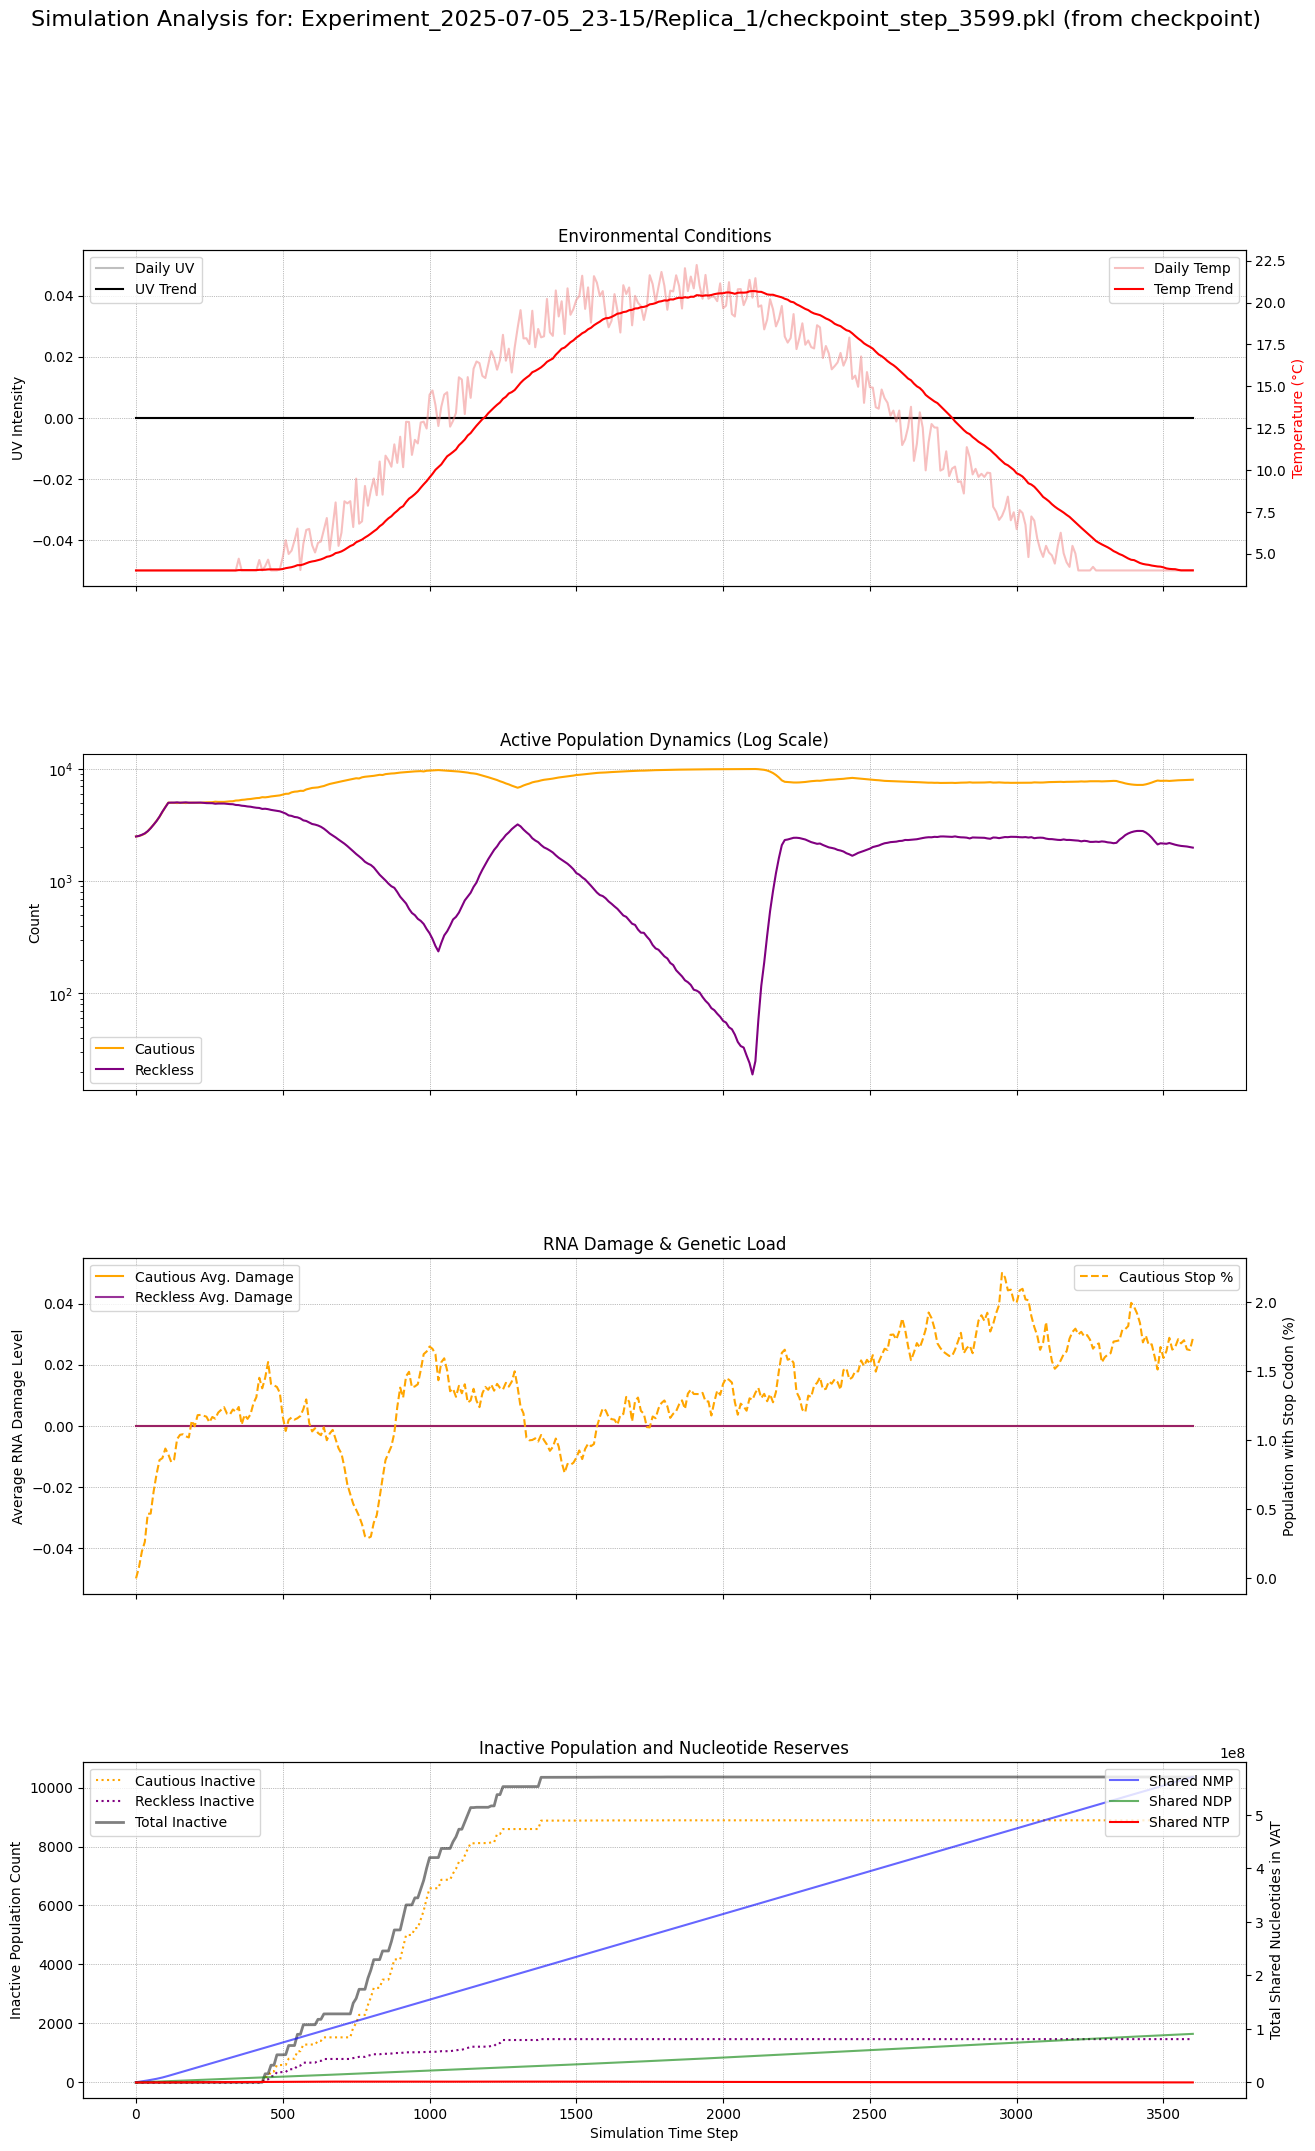

In [ ]:
%matplotlib inline
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import re
from datetime import datetime # Import datetime for comparison
from IPython.display import display # Corrected import for display

# ===================================================================
# === 1. SET THE BASE PATH TO YOUR SIMULATION EXPERIMENTS FOLDER ===
# ===================================================================
# This path should point to the folder where the Simulation Runner creates
# the timestamped experiment subfolders (e.g., 'Sim_Experiments').
BASE_EXPERIMENTS_PATH = '/content/drive/My Drive/Colab Notebooks/Sim_Experiments'
# ===================================================================

def find_latest_simulation_log(base_path):
    """
    Finds the absolute latest primary simulation log file (completed or extinct)
    or the latest checkpoint file across all replica directories in the latest
    experiment directory.
    """
    if not os.path.exists(base_path):
        print(f"Error: Base experiments path not found at {base_path}") # Corrected variable name
        return None, None # Return file path and display name

    # Find all experiment directories, sorted by creation/modification time
    experiment_dirs = sorted(
        [d for d in glob.glob(os.path.join(base_path, 'Experiment_*')) if os.path.isdir(d)],
        key=os.path.getmtime, # Use modification time for latest
        reverse=True
    )

    if not experiment_dirs:
        print(f"Error: No experiment directories found in {base_path}")
        return None, None

    # Find the absolute latest data file (log or checkpoint) across all replicas
    latest_file_path = None
    latest_file_mtime = 0 # Track modification time of the latest file
    latest_file_display_name = None

    # We only need to search the latest experiment directory found
    # Iterate through experiment_dirs starting from the latest
    for exp_dir in experiment_dirs:
        # Look for files in *all* replica directories within this experiment
        replica_dirs = [d for d in glob.glob(os.path.join(exp_dir, 'Replica_*')) if os.path.isdir(d)]

        # Sort replica directories by modification time as well to find the latest replica first
        replica_dirs.sort(key=os.path.getmtime, reverse=True)


        for rep_dir in replica_dirs:
            # Look for final logs and checkpoints in this replica directory
            possible_files = (
                glob.glob(os.path.join(rep_dir, 'simulation_log_completed.pkl')) +
                glob.glob(os.path.join(rep_dir, 'simulation_log_extinct.pkl')) +
                glob.glob(os.path.join(rep_dir, 'simulation_log.pkl')) + # Include old format
                glob.glob(os.path.join(rep_dir, 'checkpoint_step_*.pkl'))
            )

            # Sort possible files within this replica by modification time to prioritize latest
            possible_files.sort(key=os.path.getmtime, reverse=True)


            for file_path in possible_files:
                try:
                    file_mtime = os.path.getmtime(file_path)
                    # We want the ABSOLUTE latest file across all replicas and experiments
                    # So we compare against the latest_file_mtime found so far globally
                    if file_mtime > latest_file_mtime:
                        latest_file_mtime = file_mtime
                        latest_file_path = file_path
                        # Construct a display name showing experiment/replica/filename
                        rel_path = os.path.relpath(file_path, base_path)
                        latest_file_display_name = rel_path
                        # Add (from checkpoint) if it's a checkpoint
                        if 'checkpoint_step_' in os.path.basename(file_path):
                             latest_file_display_name += " (from checkpoint)"
                         # Once we find the latest file, we can stop searching
                         # This assumes the sorting by time correctly gives us the latest overall
                         # This break will exit the inner loop (over files), then the next break
                         # will exit the replica loop, and the outer break the experiment loop.
                         # No need for break here, as the sorting ensures we find the latest first
                         # The check below will handle exiting outer loops if the latest is found
                except Exception as e:
                    print(f"Error checking file {file_path}: {e}")
                    continue # Skip to the next file on error


            # After checking all files in this replica, if we have found a latest_file_path
            # and its modification time is newer than this replica directory's modification time,
            # it means the latest file isn't in a *newer* replica directory.
            # However, the sorting of replica_dirs already handles this.
            # The logic here was likely intended to optimize, but was syntactically incorrect.
            # Removing the incorrect `if latest_file_path and os.path.getmtime(rep_dir) <= latest_file_mtime:` line and its break.
            pass # Syntactically correct way to do nothing


        # After checking all replicas in this experiment, if we have found a latest_file_path
        # and its modification time is newer than this experiment directory's modification time,
        # it means the latest file isn't in a *newer* experiment directory.
        # However, the sorting of experiment_dirs already handles this.
        # Removing the incorrect `if latest_file_path and os.path.getmtime(exp_dir) <= latest_file_mtime:` line and its break.
        pass # Syntactically correct way to do nothing


    if latest_file_path:
        print(f"Found latest data file: {latest_file_display_name}")
        return latest_file_path, latest_file_display_name
    else:
        print(f"Error: No primary simulation log file or checkpoint found in any replica directory within {base_path}.")
        return None, "No data found"


def plot_simulation_details(results_df, file_name=""):
    """
    Generates and displays the four plots you specified.
    Handles potentially incomplete DataFrames gracefully.
    """
    if results_df.empty:
        print("The DataFrame is empty. No data to plot.")
        return

    # Calculate Stop Codon Percentages safely, avoiding division by zero
    # The fillna(0) handles cases where the population for a strategy is 0
    # Use the raw counts from the log for the percentage calculation
    results_df['cautious_stop_pct'] = (results_df['cautious_stop_count'] * 100 / results_df['cautious'].replace(0, np.nan)).fillna(0) # Use replace(0, np.nan) to avoid division by zero
    results_df['reckless_stop_pct'] = (results_df['readthrough_stop_count'] * 100 / results_df['readthrough'].replace(0, np.nan)).fillna(0) # This should always be 0 based on logging logic


    fig, axs = plt.subplots(4, 1, figsize=(15, 24), sharex=True, gridspec_kw={'hspace': 0.5}) # Reverted to 4 plots
    fig.suptitle(f'Simulation Analysis for: {file_name}', fontsize=16)
    colors = {'cautious': 'orange', 'readthrough': 'purple'}
    # Adjust rolling window based on data size
    # Use a window that is at most 10% of the data length, but not more than 100
    rolling_window = min(100, max(1, len(results_df) // 10))
    print(f"Using rolling window size for smoothing: {rolling_window}")


    # Plot 1: Environmental Conditions (UV and Temperature)
    ax = axs[0]
    ax.set_title('Environmental Conditions')
    ax.plot(results_df['time'], results_df['uv'], color='gray', alpha=0.5, label='Daily UV')
    # Apply rolling mean only if there's enough data points
    if len(results_df) >= rolling_window:
        ax.plot(results_df['time'], results_df['uv'].rolling(window=rolling_window, min_periods=1).mean(), color='black', label='UV Trend')
    else:
         ax.plot(results_df['time'], results_df['uv'].rolling(window=len(results_df)//2 or 1, min_periods=1).mean(), color='black', label='UV Trend (Smoothed)') # Use smaller window if data is short

    ax.set_ylabel('UV Intensity'); ax.legend(loc='upper left')
    ax_t = ax.twinx()
    ax_t.plot(results_df['time'], results_df['temp'], color='lightcoral', alpha=0.5, label='Daily Temp')
    # Apply rolling mean only if there's enough data points
    if len(results_df) >= rolling_window:
        ax_t.plot(results_df['time'], results_df['temp'].rolling(window=rolling_window, min_periods=1).mean(), color='red', label='Temp Trend')
    else:
        ax_t.plot(results_df['time'], results_df['temp'].rolling(window=len(results_df)//2 or 1, min_periods=1).mean(), color='red', label='Temp Trend (Smoothed)') # Use smaller window if data is short

    ax_t.set_ylabel('Temperature (°C)', color='r'); ax_t.legend(loc='upper right')

    # Plot 2: Population Dynamics (Log Scale)
    ax = axs[1] # Changed to use the second subplot (index 1)
    ax.set_title('Active Population Dynamics (Log Scale)')
    # Only plot if columns exist and have data
    if 'cautious' in results_df.columns and not results_df['cautious'].isnull().all():
        ax.plot(results_df['time'], results_df['cautious'], label='Cautious', color=colors['cautious'])
    if 'readthrough' in results_df.columns and not results_df['readthrough'].isnull().all():
        ax.plot(results_df['time'], results_df['readthrough'], label='Reckless', color=colors['readthrough'])

    ax.set_yscale('log'); ax.set_ylabel('Count'); ax.legend()
    # Handle cases where log scale might fail due to zero values
    if (results_df['cautious'] == 0).all() and (results_df['readthrough'] == 0).all():
         ax.set_yscale('linear') # Switch to linear scale if all are zero
         ax.set_title('Active Population Dynamics (Linear Scale - All Zero)')


    # Plot 3: RNA Damage & Genetic Load
    ax = axs[2] # Changed to use the third subplot (index 2)
    ax.set_title('RNA Damage & Genetic Load')
    # Only plot if columns exist and have data
    if 'cautious_avg_damage' in results_df.columns and not results_df['cautious_avg_damage'].isnull().all():
        ax.plot(results_df['time'], results_df['cautious_avg_damage'], label='Cautious Avg. Damage', color=colors['cautious'])
    if 'readthrough_avg_damage' in results_df.columns and not results_df['readthrough_avg_damage'].isnull().all():
        ax.plot(results_df['time'], results_df['readthrough_avg_damage'], label='Reckless Avg. Damage', color=colors['readthrough'], alpha=0.8)

    ax.set_ylabel('Average RNA Damage Level'); ax.legend(loc='upper left')
    ax_t = ax.twinx()
    # Only plot if columns exist and have data
    if 'cautious_stop_pct' in results_df.columns and not results_df['cautious_stop_pct'].isnull().all() and not (results_df['cautious_stop_pct'] == 0).all(): # Only plot if there's non-zero data
        ax_t.plot(results_df['time'], results_df['cautious_stop_pct'], label='Cautious Stop %', color=colors['cautious'], linestyle='--')
    if 'reckless_stop_pct' in results_df.columns and not results_df['reckless_stop_pct'].isnull().all() and not (results_df['reckless_stop_pct'] == 0).all(): # Only plot if there's non-zero data
        # This should always be 0 if logging is correct, but plotting it confirms
        ax_t.plot(results_df['time'], results_df['reckless_stop_pct'], label='Reckless Stop %', color=colors['readthrough'], linestyle='--')

    ax_t.set_ylabel('Population with Stop Codon (%)'); ax_t.legend(loc='upper right')


    # Plot 4: Inactives and Nucleotide Pools
    ax = axs[3] # Changed to use the fourth subplot (index 3)
    ax.set_title('Inactive Population and Nucleotide Reserves')
    # Plot separate inactive counts if available and data exists
    if 'cautious_inactive_count' in results_df.columns and not results_df['cautious_inactive_count'].isnull().all() and not (results_df['cautious_inactive_count'] == 0).all():
        ax.plot(results_df['time'], results_df['cautious_inactive_count'], label='Cautious Inactive', color=colors['cautious'], linestyle=':')
    if 'readthrough_inactive_count' in results_df.columns and not results_df['readthrough_inactive_count'].isnull().all() and not (results_df['readthrough_inactive_count'] == 0).all():
        ax.plot(results_df['time'], results_df['readthrough_inactive_count'], label='Reckless Inactive', color=colors['readthrough'], linestyle=':')
    # Keep total inactive plot for reference if needed, plot only if not all zero
    if 'inactive' in results_df.columns and not results_df['inactive'].isnull().all() and not (results_df['inactive'] == 0).all():
        ax.plot(results_df['time'], results_df['inactive'], label='Total Inactive', color='black', lw=2, alpha=0.5)
    # If all inactive counts (total and separate) are zero, ensure the y-axis is not log and title reflects zero
    if (results_df['cautious_inactive_count'] == 0).all() and (results_df['readthrough_inactive_count'] == 0).all() and (results_df['inactive'] == 0).all():
         ax.set_title('Inactive Population (All Zero)')


    ax.set_ylabel('Inactive Population Count'); ax.legend(loc='upper left')
    ax_t = ax.twinx()

    # Only plot if columns exist and have data
    # Check if any nucleotide data exists before attempting to plot or show legend for twinx
    nucleotide_cols = ['shared_nmp_total', 'shared_ndp_total', 'shared_ntp_total'] # Updated column names for shared pools
    if any(col in results_df.columns and not results_df[col].isnull().all() and not (results_df[col] == 0).all() for col in nucleotide_cols): # Only plot if there's non-zero data
        # Plot shared nucleotide pools
        if 'shared_nmp_total' in results_df.columns and not results_df['shared_nmp_total'].isnull().all() and not (results_df['shared_nmp_total'] == 0).all():
            ax_t.plot(results_df['time'], results_df['shared_nmp_total'], color='blue', alpha=0.6, label='Shared NMP')
        if 'shared_ndp_total' in results_df.columns and not results_df['shared_ndp_total'].isnull().all() and not (results_df['shared_ndp_total'] == 0).all():
            ax_t.plot(results_df['time'], results_df['shared_ndp_total'], color='green', alpha=0.6, label='Shared NDP')
        if 'shared_ntp_total' in results_df.columns and not results_df['shared_ntp_total'].isnull().all() and not (results_df['shared_ntp_total'] == 0).all():
            ax_t.plot(results_df['time'], results_df['shared_ntp_total'], color='red', alpha=1.0, label='Shared NTP')


        ax_t.set_ylabel('Total Shared Nucleotides in VAT') # Removed color here
        # Only show legend for ax_t if any nucleotide data was plotted on it
        handles_t, labels_t = ax_t.get_legend_handles_labels()
        if handles_t:
             ax_t.legend(loc='upper right')


    for ax_item in axs:
        ax_item.grid(True, linestyle=':', linewidth='0.5', color='gray')
        # Set x-label only on the bottom plot
        if ax_item == axs[-1]:
             ax_item.set_xlabel('Simulation Time Step')
        else:
             ax_item.set_xlabel('') # Remove x-label from upper plots


    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust rect to make space for suptitle
    plt.show()
    plt.close(fig)

# --- Main Execution Logic for this Cell ---
DATA_FILE_PATH, DISPLAY_FILE_NAME = find_latest_simulation_log(BASE_EXPERIMENTS_PATH)

# Initialize results_df to an empty DataFrame before loading
results_df = pd.DataFrame()

if DATA_FILE_PATH and os.path.exists(DATA_FILE_PATH):
    try:
        print(f"Loading data from {os.path.basename(DATA_FILE_PATH)}...")
        with open(DATA_FILE_PATH, 'rb') as f:
            saved_data = pickle.load(f)

        # Check if the loaded data is a full state (from checkpoint) or just the log
        if isinstance(saved_data, dict) and 'log' in saved_data:
            # It's a log file (from a completed/extinct run or older format, or periodically saved log)
            # Ensure data is assigned to results_df only here
            results_df = pd.DataFrame(saved_data['log'])
            print(f"Successfully loaded log with {len(results_df)} entries.")
        elif isinstance(saved_data, dict) and 'step' in saved_data and 'colony' in saved_data and 'environment' in saved_data:
            # It's a checkpoint file containing the full state.
            # Load the data_log which is now saved within the checkpoint state
            if 'log' in saved_data:
                 results_df = pd.DataFrame(saved_data['log'])
                 print(f"Successfully loaded data_log from checkpoint with {len(results_df)} entries.")
            else:
                 print("Error: Checkpoint file does not contain a saved 'log'. Cannot plot from this checkpoint format.")
                 print("Please ensure the simulation is running with the latest code that saves the data_log within checkpoints.")
                 # If loading fails, ensure results_df remains empty
                 results_df = pd.DataFrame() # Explicitly set to empty


        else:
            print("Error: The loaded pickle file has an unexpected format.")
            print(f"Loaded data type: {type(saved_data)}")
            # If loading fails, ensure results_df remains empty
            results_df = pd.DataFrame() # Explicitly set to empty


    except Exception as e:
        print(f"\n--- ERROR: Could not load or plot the data file. ---")
        print(f"The error was: {e}")
        # If loading fails, ensure results_df remains empty
        results_df = pd.DataFrame() # Explicitly set to empty

else:
    print(f"--- ERROR: Could not find or access the latest simulation log file or checkpoint. ---")
    print(f"Please ensure the BASE_EXPERIMENTS_PATH is correct and that simulation runs have completed or been interrupted after at least one checkpoint was saved.")
    # If no file found, ensure results_df remains empty
    results_df = pd.DataFrame() # Explicitly set to empty


# Only attempt to plot if results_df is not empty
if not results_df.empty:
    plot_simulation_details(results_df, file_name=DISPLAY_FILE_NAME)
else:
    print("No data loaded into DataFrame to plot.")